# **Mountain Car (Discrete case)**

References :

SARSA:  https://github.com/nicklasbekkevold/SARSA-mountaincar

SARSA (lambda) : https://github.com/dariopavllo/mountaincar-sarsa-lambda

Semi-Gradient SARSA : https://github.com/MikeS96/rl_openai/blob/master/Mountain%20Car.ipynb
http://www.incompleteideas.net/book/RLbook2018.pdf#page=267


PPO:    https://github.com/rossettisimone/PPO_MOUNTAINCAR_DISCRETE.

Reddit: www.reddit.com/r/reinforcementlearning/comments/axp63j/d_state_of_the_art_deeprl_still_struggles_to/.  
https://arxiv.org/pdf/1802.05054


Documentation pour la librairie tiles3 : http://incompleteideas.net/tiles/tiles3.html


Q-learning : https://www.kaggle.com/code/rezafazel63/mountain-car-is-a-classic-reinforcement-learning


  

# Google Colab configs

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [1]:
!pip install gym
!pip install gym[classic_control]
!pip install pyvirtualdisplay


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [95 lines of output]
      
      
      WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
      Using WINDOWS configuration...
      
      Making dir :prebuilt_downloads:
      Downloading... https://www.libsdl.org/release/SDL2-devel-2.0.16-VC.zip 13d952c333f3c2ebe9b7bc0075b4ad2f784e7584
      Unzipping :prebuilt_downloads\SDL2-devel-2.0.16-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_image/release/SDL2_image-devel-2.0.5-VC.zip 137f86474691f4e12e76e07d58d5920c8d844d5b
      Unzipping :prebuilt_downloads\SDL2_image-devel-2.0.5-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_ttf/release/SDL2_ttf-devel-2.0.15-VC.zip 1436df41ebc47ac36e02ec9bda5699e80ff9bd27
      Unzipping :prebuilt_downloads\SDL2_ttf-devel-2.0.15-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_mixer/release/SDL2_mixer-devel-


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# !apt-get install -y xvfb


def wrap_env(env):
    env = RecordVideo(env, "./video")
    return env


def show_video():
    mp4list = glob.glob("video/*.mp4")
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, "r+b").read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(
            HTML(
                data="""<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>""".format(
                    encoded.decode("ascii")
                )
            )
        )
    else:
        print("Could not find video")


# A executer avant l'initialisation de env
# display = Display(visible=0, size=(1400, 900))
# display.start()
# env = wrap_env(gym.make('MountainCar-v0'))

# Libraries

In [5]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# from gym.wrappers.record_video import RecordVideo
# import glob
# import io
# import base64
# from IPython.display import HTML
# from pyvirtualdisplay import Display
# from IPython import display as ipythondisplay

# 1. Functions & Algorithms

## 1.1. Utils

In [7]:
import math
import random


class IHT:
    """
    Index Hash Table Class for tile encoding from http://incompleteideas.net/tiles/tiles3.html
    Developed by Richard S. Sutton
    """

    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        return (
            "Collision table: size: "
            + str(self.size)
            + " overfullCount: "
            + str(self.overfullCount)
            + " dictionary: "
            + str(len(self.dictionary))
        )

    def count(self):
        return len(self.dictionary)

    def fullp(self):
        return len(self.dictionary) >= self.size

    def getindex(self, obj, readonly=False):
        if obj in self.dictionary:
            return self.dictionary[obj]
        elif readonly:
            return None
        size = self.size
        if len(self.dictionary) >= size:
            if self.overfullCount == 0:
                print("IHT full, starting to allow collisions")
            self.overfullCount += 1
            return hash(obj) % self.size
        else:
            self.dictionary[obj] = len(self.dictionary)
            return self.dictionary[obj]


def hashcoords(coordinates, m, readonly=False):
    if isinstance(m, IHT):
        return m.getindex(tuple(coordinates), readonly)
    if isinstance(m, int):
        return hash(tuple(coordinates)) % m
    if m is None:
        return coordinates


def get_tiles(ihtORsize, numtilings, floats, ints=[], readonly=False):
    qfloats = [int(math.floor(f * numtilings)) for f in floats]
    tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // numtilings)
            b += tilingX2
        coords.extend(ints)
        tiles.append(hashcoords(coords, ihtORsize, readonly))
    return tiles

In [8]:
POSITION_MIN = -1.2
POSITION_MAX = 0.5
VELOCITY_MIN = -0.07
VELOCITY_MAX = 0.07

iht_size = 2024
num_tilings = 8
num_tiles = 8

iht = IHT(2024)


def mc_tile_encoding(state):
    """
    Tile encoding function for states in mountain car gymnasium problem

    Args:
        - state (tuple): (position, velocity)

    Returns:
        - The list of the tiles corresponding to the given state
    """
    # Extract the position and velocity from the gymnasium state
    position, velocity = state

    # Scale position and velocity by multiplying the inputs of each by their scale
    position_scale = num_tiles / (POSITION_MAX - POSITION_MIN)
    velocity_scale = num_tiles / (VELOCITY_MAX - VELOCITY_MIN)

    # Obtain active tiles for current position and velocity
    tiles = get_tiles(
        iht, num_tilings, [position * position_scale, velocity * velocity_scale]
    )

    return np.array(tiles)


print("Tiles activées :", mc_tile_encoding((-1.0, 0.01)))

Tiles activées : [0 1 2 3 4 5 6 7]


In [ ]:
## Second Option for Tile Coding implementation 

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [9]:
def plot_moving_averages(rewards_dict, nb_episodes, window_size):
    """
    Plots the moving averages and standard deviation of rewards for multiple reward histories
    on the same graph, with named histories provided in a dictionary.

    Args:
        - rewards_dict (dict): A dictionary where keys are parameter combinations
          and values are {"avg": list, "std": list}
        - nb_episodes (int): Total number of episodes per training iteration.
        - window_size (int): The size of the moving average window.

    Returns:
        None
    """
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(12, 8))

    for param_key, data in rewards_dict.items():
        # Calculate the moving average using np.convolve
        moving_avg_rewards = np.convolve(
            data["avg"], np.ones(window_size) / window_size, mode="valid"
        )

        # Calculate the standard deviation for the same window
        std_rewards = [
            np.std(data["avg"][i : i + window_size])
            for i in range(len(data["avg"]) - window_size + 1)
        ]

        x_range = range(len(moving_avg_rewards))

        # Plot the moving average
        plt.plot(
            x_range,
            moving_avg_rewards,
            label=param_key,
        )

        # Plot the shaded standard deviation area
        plt.fill_between(
            x_range,
            moving_avg_rewards - std_rewards,
            moving_avg_rewards + std_rewards,
            alpha=0.2,  # Transparency for the shaded area
        )

    plt.xlabel("Number of Episodes")
    plt.ylabel("Moving Average of Rewards with Standard Deviation")
    plt.title(
        f"Comparison of {window_size}-Episode Moving Averages with Standard Deviations"
    )
    plt.legend()
    plt.grid()
    plt.show()

## 1.2. Agents

### 1.2.1. SARSA Agent

In [11]:
class SarsaAgent:
    """
    Theoretical guarantees: https://sites.ualberta.ca/~szepesva/papers/sarsa98.ps.pdf
    """

    def __init__(
        self,
        env: gym.Env,
        encode_fct,
        nb_actions=None,
    ):
        """
        - env_name (gymnasium.Env): The environment to train on.
        - nb_actions (int): Number of possible actions.
        - encode_fct (callable): Function to encode the state into features (e.g., tile coding).
        """
        self.env = env
        self.nb_actions = env.action_space.n if nb_actions == None else nb_actions
        self.encode_fct = encode_fct
        self.q = {}
        self.tune_historic = {}

    def init(self):
        """Initialize agent and environment"""
        self.env.reset()
        self.q = {}

    def get_q_value(self, state, action):
        """Compute Q-value for a state-action pair by summing over the tiles."""
        return sum(self.q.get((tile, action), 0) for tile in self.encode_fct(state))

    def choose_action(self, state, epsilon=None, soft_policy=True):
        """
        Choose an action using an epsilon-greedy policy.

        Args:
        - q (dict): The Q-value dictionary.
        - state (hashable): The current state.
        - epsilon (float, optional): The probability of exploration (for soft policy).
        - soft_policy (bool, optional): If True, use epsilon-greedy; otherwise, choose the action with the highest Q-value.

        Returns:
        - int: The selected action.

        Raises:
        - ValueError: If soft_policy is True and epsilon is None.
        """
        if (soft_policy) and (epsilon is None):
            raise ValueError("Epsilon must be specified when soft_policy is True.")

        if (soft_policy) and (np.random.rand() < epsilon):
            return np.random.choice(self.nb_actions)  # Exploration
        return np.argmax(
            [self.get_q_value(state, action) for action in range(self.nb_actions)]
        )

    def update_epsilon(self, epsilon, nb_episodes, episode):
        """
        Update epsilon following a GLEI (Greedy to the Limit to Exploration Infinite)

        Args:
            - epsilon (float): exploration rate to update
            - nb_episodes (int): total number of episodes
            - nb_
        """
        return epsilon

    def train(
        self,
        nb_episodes,
        alpha=0.1,
        gamma=0.99,
        epsilon=0.1,
        use_glei=False,
        min_epsilon=0.005,
        verbose=False,
    ):
        """
        SARSA algorithm for on-policy reinforcement learning.

        Args:
            - nb_episodes (int): Number of episodes to train for.
            - alpha (float): Learning rate for updating Q-values.
            - gamma (float): Discount factor for future rewards.
            - epsilon (float): Initial exploration rate for epsilon-greedy policy.
            - use_glei (bool): Whether to use a decaying epsilon (GLEI policy). Devide epislon by 2 every (nb_episodes // 5) episodes
            - min_epsilon (float): Minimum epsilon value in GLEI policy.
            - verbose (boolean): Print or not informations about training
        Returns:
            - rewards_historic (list): History of rewards across episodes.
        """
        # Initializations
        self.init()
        self.q["Params"] = {
            "Nb training period": nb_episodes,
            "alpha": alpha,
            "epsilon": epsilon,
            "GLEI": use_glei,
        }
        rewads_historic = []
        epsilon

        for episode in range(nb_episodes):
            # Decay epsilon if we use a glei learning
            if (use_glei) and (episode % (nb_episodes // 5) == 0 and episode > 0):
                if not (epsilon / 2 < min_epsilon):
                    epsilon /= 2
                    if verbose:
                        print(f"\nEpsilon updated to: {epsilon}\n")

            state, _ = self.env.reset()
            action = self.choose_action(state, epsilon=epsilon)

            task_completed, episode_over = False, False
            total_reward = 0

            while not (task_completed or episode_over):
                next_state, reward, task_completed, episode_over, _ = self.env.step(
                    action
                )
                next_action = self.choose_action(next_state, epsilon=epsilon)

                # Compute the SARSA update
                q_current = self.get_q_value(state, action)
                q_next = (
                    self.get_q_value(next_state, next_action)
                    if not (task_completed or episode_over)
                    else 0
                )
                target = reward + gamma * q_next
                error = target - q_current

                # Update Q-values for all tiles
                for tile in self.encode_fct(state):
                    self.q[(tile, action)] = (
                        self.q.get((tile, action), 0) + alpha * error
                    )

                # Move to the next state and action
                state = next_state
                action = next_action
                total_reward += reward

            rewads_historic.append(total_reward)
            if verbose:
                print(f"Episode {episode + 1}: Total Reward = {total_reward}")

        return rewads_historic

    def evaluate_policy(
        self, num_episodes=10, soft_policy=False, render_mode=None, verbose=False
    ):
        """
        Evaluate the current Q-values of the agent and print the average reward.

        Args:
            num_episodes (int): Number of episodes to evaluate the policy.
            soft_policy (bool): If True, uses an epsilon-greedy policy for action selection.
                                If False, selects the action with the highest Q-value (greedy policy).
            render_mode (str, optional): Rendering mode for the environment. For example, "human" to visualize the environment.
            verbose (bool): If True, prints detailed information about the evaluation process,
                            including training parameters and rewards for each episode.

        Returns:
            float: The average reward obtained over the evaluated episodes.
        """
        if verbose:
            print(f"Training parameters:\n", f"{self.q['Params']}")
            print(f"\nEvaluation:")
        env = gym.make("MountainCar-v0", render_mode=render_mode)
        total_rewards = []

        for episode in range(num_episodes):
            state, _ = env.reset()
            time_over = False
            done = False
            total_reward = 0

            while not (done or time_over):
                # Exécuter l'action choisie
                state, reward, done, time_over, _ = env.step(
                    self.choose_action(state, soft_policy=soft_policy)
                )
                total_reward += reward

            total_rewards.append(total_reward)
            if verbose:
                print(f"Episode {episode + 1}: Total Reward = {total_reward}")

        env.close()
        print(
            f"Average Total Reward over {num_episodes} episodes: {np.mean(total_rewards)}"
        )

        return np.mean(total_rewards)

    def grid_search(
        self,
        alpha_values=[0.001, 0.1, 0.2],
        gamma_values=[0.99],
        epsilon_values=[0.01, 0.1, 0.2],
        nb_episodes=1000,
        nb_iter=10,
        use_glei=False,
        verbose=False,
    ):
        """
        Perform a grid search over hyperparameters for the SARSA agent.

        Metrics used:
            - Optimality: the best average reward on the last 10% training episodes.
            - Convergence speed: the smallest number of training episodes to reach the optimality ± 0.1%.

        Args:
            - alpha_values (list): Learning rates to test.
            - gamma_values (list): Discount factors to test.
            - epsilon_values (list): Exploration rates to test.
            - nb_episodes (int): Number of episodes per training iteration.
            - nb_iter (int): Number of iterations for averaging results.
            - moving_avg_size (int): Window size for the moving average in plotting.
            - verbose (bool): If True, print details of the training process.

        Returns:
            dict: A ranking of hyperparameter sets based on the metrics.
        """
        self.tune_historic = {}
        rankings = []
        if verbose:
            print("Using glei training: ", use_glei)
        # Iterate over all combinations of parameters
        for epsilon in epsilon_values:
            for alpha in alpha_values:
                for gamma in gamma_values:
                    if verbose:
                        print(
                            f"Processing:\nepsilon={epsilon}\nalpha={alpha}\ngamma={gamma}\n"
                        )
                    param_key = f"epsilon={epsilon}_alpha={alpha}_gamma={gamma}"
                    data = np.empty((nb_iter, nb_episodes))
                    for iteration in range(nb_iter):
                        if verbose:
                            print(
                                f"Iteration {iteration + 1}/{nb_iter} for {param_key}"
                            )

                        rewards = self.train(
                            nb_episodes=nb_episodes,
                            alpha=alpha,
                            gamma=gamma,
                            epsilon=epsilon,
                            use_glei=use_glei,
                            verbose=False,
                        )
                        data[iteration] = rewards

                    self.tune_historic[param_key] = {
                        "avg": np.mean(data, axis=0),
                        "std": np.std(data, axis=0),
                    }

        #             optimality = np.mean(avg_rewards[-int(0.1 * nb_episodes) :])

        #             # Convergence speed: first episode where average reward is within 0.1% of optimality
        #             convergence_speed = next(
        #                 (
        #                     i
        #                     for i, reward in enumerate(avg_rewards)
        #                     if abs(reward - optimality) <= 0.001 * optimality
        #                 ),
        #                 nb_episodes,
        #             )

        #             rankings.append(
        #                 {
        #                     "params": param_key,
        #                     "optimality": optimality,
        #                     "convergence_speed": convergence_speed,
        #                 }
        #             )

        # # Sort rankings by optimality (descending) and then by convergence speed (ascending)
        # rankings = sorted(
        #     rankings,
        #     key=lambda x: (-x["optimality"], x["convergence_speed"]),
        # )
        # if verbose:
        #     print("\nRanking of parameter sets:")
        #     for rank, entry in enumerate(rankings, start=1):
        #         print(
        #             f"{rank}: {entry['params']} - Optimality: {entry['optimality']:.3f}, Convergence Speed: {entry['convergence_speed']}"
        #         )

        # return rankings

### 1.2.2. Semi-Gradient SARSA Agent

In [49]:
import pickle
import random
import numpy as np
import gymnasium as gym

random.seed(18)

class SemiGradientSarsa(object):
    def __init__(
        self,
        env,
        alpha=0.01, 
        eps=0.1,
        gamma=1,
        n_tilings = 7,
        num_eps=100) -> None:
        self.alpha = alpha
        self.eps = eps
        self.gamma = gamma
        self.num_eps = num_eps
        self.n_tilings = n_tilings
        self.env = env
        
        # Initialize weights, random values close to 0 (size = 2401, for n_tilings = 7)
        self.w = np.random.uniform(low=-0.05, high=0.05, size=(n_tilings**4,))

        # hash for tile coding
        self.tile_coding = IHT(n_tilings**4)

    def q_func(self, feature_vector):
        return np.dot(self.w, feature_vector)

    def update_weight(self, reward, current_q, future_q, feature_vector, terminal):
        if terminal:
            w_update = self.alpha * (reward - current_q)
        else:
            w_update = self.alpha * (reward + self.gamma *future_q - current_q)
        self.w += np.multiply(w_update, feature_vector)


    def train(self):
        state, info = self.env.reset()
        print("Initial State    : ", state)
        action, q = self.select_action(state)
        episodes = 0
        steps = 0

        total_reward = 0

        while episodes < self.num_eps:
            steps += 1

            feature_vec = self.hash_feature_vector(state, action)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward

            if terminated:

                if episodes % 50 == 0:
                    print("episode:", episodes, 'completed', 'reward:', total_reward)
                
                self.update_weight(reward, q, None, feature_vec, True)
                state, info = self.env.reset()
                action, q = self.select_action(state)
                total_reward = 0
                steps = 0
                episodes += 1

                continue

            next_action, next_q = self.select_action(next_state)
            self.update_weight(reward, q, next_q, feature_vec, False)
            state = next_state
            action = next_action
            q = next_q
            
        self.save_params()
    
    def save_params(self):
        print(self.w)
        pickle.dump(self.w, open('weights.pkl', 'wb'))
        pickle.dump(self.tile_coding, open('tilings.pkl', 'wb'))
    
    def load_params(self):
        self.w = pickle.load(open('weights.pkl', 'rb'))
        self.tile_coding = pickle.load(open('tilings.pkl', 'rb'))

    def one_hot_encode(self, indices):
        size = len(self.w)
        one_hot_vec = np.zeros(size)
        for i in indices:
            one_hot_vec[i] = 1
        return one_hot_vec

    def hash_feature_vector(self, state, action):
        # speed you up
        feature_ind = np.array(tiles(self.tile_coding, self.n_tilings, state.tolist(), [action]))
        feature_vec = self.one_hot_encode(feature_ind)
        return feature_vec

    def select_action(self, state, eps_greedy = True):
        num_actions = self.env.action_space.n
        actions = range(num_actions)
        action_val_dict = {}
        for action in actions:
            feature_vector = self.hash_feature_vector(state, action)
            q_val = self.q_func(np.array(feature_vector))

            action_val_dict[action] = q_val
        
        greedy_action = max(action_val_dict, key=action_val_dict.get)
        
        if not eps_greedy:
            return greedy_action

        non_greedy_actions = list(set(range(num_actions)) - {greedy_action})
        
        prob_explorative_action = self.eps / num_actions
        prob_greedy_action = 1 - self.eps + prob_explorative_action

        action = np.random.choice([greedy_action] + non_greedy_actions,
                    p=[prob_greedy_action]+[prob_explorative_action for _ in range(len(non_greedy_actions))])
        return action, action_val_dict[action]

# 2. Experimentations

## 2.1. Testing agent

In [12]:
# Set up the agent
v0_agent = SarsaAgent(env=gym.make("MountainCar-v0"), encode_fct=mc_tile_encoding)

# Train the agent
_ = v0_agent.train(nb_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.001)

# Evaluate the q values
v0_agent.evaluate_policy(verbose=True, render_mode=None)

Training parameters:
 {'Nb training period': 1000, 'alpha': 0.1, 'epsilon': 0.001, 'GLEI': False}

Evaluation:
Episode 1: Total Reward = -86.0
Episode 2: Total Reward = -156.0
Episode 3: Total Reward = -107.0
Episode 4: Total Reward = -197.0
Episode 5: Total Reward = -108.0
Episode 6: Total Reward = -107.0
Episode 7: Total Reward = -107.0
Episode 8: Total Reward = -89.0
Episode 9: Total Reward = -107.0
Episode 10: Total Reward = -86.0
Average Total Reward over 10 episodes: -115.0


np.float64(-115.0)

In [13]:
# Set up the agent
glei_agent = SarsaAgent(env=gym.make("MountainCar-v0"), encode_fct=mc_tile_encoding)

# Train the agent
_ = glei_agent.train(
    nb_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.6, use_glei=True
)

# Evaluate the q values
glei_agent.evaluate_policy(verbose=True, render_mode=None)

Training parameters:
 {'Nb training period': 1000, 'alpha': 0.1, 'epsilon': 0.6, 'GLEI': True}

Evaluation:
Episode 1: Total Reward = -106.0
Episode 2: Total Reward = -106.0
Episode 3: Total Reward = -106.0
Episode 4: Total Reward = -106.0
Episode 5: Total Reward = -106.0
Episode 6: Total Reward = -106.0
Episode 7: Total Reward = -107.0
Episode 8: Total Reward = -106.0
Episode 9: Total Reward = -157.0
Episode 10: Total Reward = -106.0
Average Total Reward over 10 episodes: -111.2


np.float64(-111.2)

In [53]:
# Semi-Gardient SARSA

# add `.env` at the end to ignore internal truncation
env = gym.make("MountainCar-v0", render_mode=None)

sarsa = SemiGradientSarsa(env, num_eps=500, alpha=0.01)
sarsa.train()

Initial State    :  [-0.4186292  0.       ]
episode: 0 completed reward: -4813.0
episode: 50 completed reward: -308.0
episode: 100 completed reward: -224.0
episode: 150 completed reward: -222.0
episode: 200 completed reward: -218.0
episode: 250 completed reward: -376.0
episode: 300 completed reward: -212.0
episode: 350 completed reward: -298.0
episode: 400 completed reward: -222.0
episode: 450 completed reward: -309.0
[-7.88319012e+00 -4.47012705e+01 -5.19000831e+01 ... -2.69368443e-02
  3.62355062e-02 -2.15427607e-02]


In [54]:
import time
import random

random.seed(10)

env_ = gym.make("MountainCar-v0", render_mode=None)

sarsa = SemiGradientSarsa(env_)
sarsa.load_params()

env = gym.make("MountainCar-v0", render_mode='human')
state, info = env.reset()

for i in range(300):
    action = sarsa.select_action(state, eps_greedy=False)
    next_state, reward, terminated, truncated, info = env.step(action)

    # Render the env
    env.render()

    # Pour avoir une animation plus visible
    time.sleep(0.001)

    state = next_state

env.close()

## 2.2. Tuning agent

In [14]:
v0_agent.grid_search(
    alpha_values=[0.1],
    gamma_values=[0.99],
    epsilon_values=[0.01, 0.1, 0.2, 0.4, 0.6, 0.8],
    nb_episodes=1000,
    nb_iter=10,
    use_glei=True,
    verbose=True,
)

Using glei training:  True
Processing:
epsilon=0.01
alpha=0.1
gamma=0.99

Iteration 1/10 for epsilon=0.01_alpha=0.1_gamma=0.99
Iteration 2/10 for epsilon=0.01_alpha=0.1_gamma=0.99
Iteration 3/10 for epsilon=0.01_alpha=0.1_gamma=0.99
Iteration 4/10 for epsilon=0.01_alpha=0.1_gamma=0.99
Iteration 5/10 for epsilon=0.01_alpha=0.1_gamma=0.99
Iteration 6/10 for epsilon=0.01_alpha=0.1_gamma=0.99
Iteration 7/10 for epsilon=0.01_alpha=0.1_gamma=0.99
Iteration 8/10 for epsilon=0.01_alpha=0.1_gamma=0.99
Iteration 9/10 for epsilon=0.01_alpha=0.1_gamma=0.99
Iteration 10/10 for epsilon=0.01_alpha=0.1_gamma=0.99
Processing:
epsilon=0.1
alpha=0.1
gamma=0.99

Iteration 1/10 for epsilon=0.1_alpha=0.1_gamma=0.99
Iteration 2/10 for epsilon=0.1_alpha=0.1_gamma=0.99
Iteration 3/10 for epsilon=0.1_alpha=0.1_gamma=0.99
Iteration 4/10 for epsilon=0.1_alpha=0.1_gamma=0.99
Iteration 5/10 for epsilon=0.1_alpha=0.1_gamma=0.99
Iteration 6/10 for epsilon=0.1_alpha=0.1_gamma=0.99
Iteration 7/10 for epsilon=0.1_alpha=

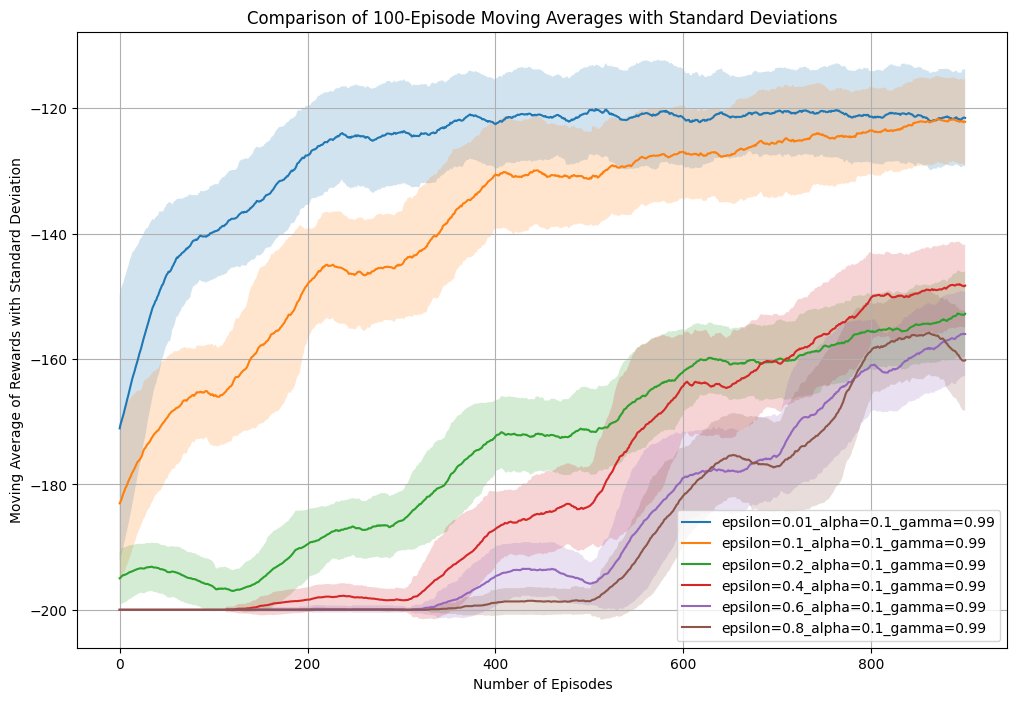

In [15]:
plot_moving_averages(v0_agent.tune_historic, nb_episodes=1000, window_size=100)

In [22]:
import json

file_name = "sarsa_grid_search_data.json"

# Save the dictionary to a JSON file
with open(file_name, "w") as json_file:
    json.dump(v0_agent.tune_historic, json_file, indent=4)

print(v0_agent.tune_historic)

TypeError: Object of type ndarray is not JSON serializable

In [92]:
# Specify the file name
file_name = "sarsa_grid_search_data.json"

# Load the JSON file into a Python dictionary
with open(file_name, "r") as json_file:
    tune_historic = json.load(json_file)

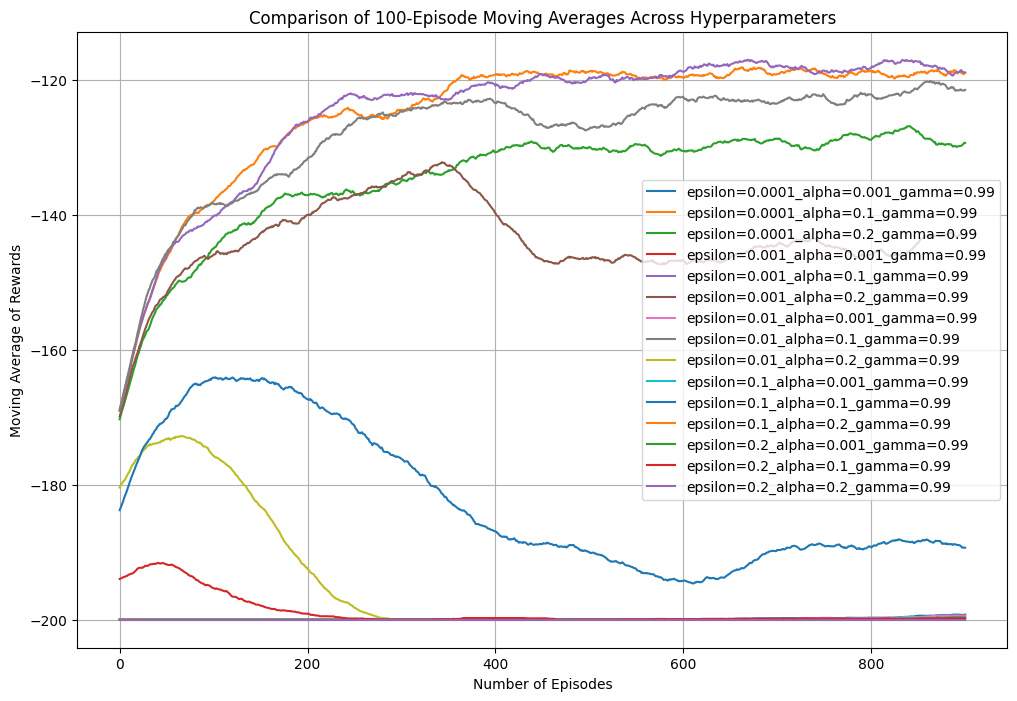

In [95]:
plot_moving_averages(tune_historic, nb_episodes=1000, window_size=100)